In [1]:
# general tools
import sys
from glob import glob
from datetime import datetime, timedelta

# data tools
import h5py
import numpy as np
from joblib import dump, load # <-- for loading sklearn models

# graph tools
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import cmaps
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# custom tools
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/')
from namelist import *
import data_utils as du
import graph_utils as gu
import verif_utils as vu
import model_utils as mu
import train_utils as tu


In [2]:
%matplotlib inline

# Global settings

### File path and names

In [3]:
DATA_dir = PRISM_dir
RESULT_dir = save_dir
feature_name = 'PRISM_PCT_features_2015_2020.hdf'

# result files
PCT_PRED_name = 'OLD_results/PRISM_PRED_NCEP_PCT_2016_2018.hdf'

SAVE_dir = save_dir # place for backup temporaal files

### HDF keys

In [4]:
PCT_keys = ['UNET_A', 'XNET_A', 'PCT_REGRID', 'PRISM_PCT']
# calculation keys
PCT_keys_pred = ['PCT_REGRID', 'UNET_A', 'XNET_A', 'PRISM_PCT']
# other keys
domains = ['train', 'trans']
seasons = ['djf', 'mam', 'jja', 'son']

In [5]:
N_all = 366 + 365 + 365 - 1
all_list = [datetime(2016, 1, 1, 0) + timedelta(days=x) for x in range(N_all)]
# time range for plotting (2018-2019)
N_pred = 365 - 1
pred_list = [datetime(2018, 1, 1, 0) + timedelta(days=x) for x in range(N_pred)]
# indices
ind_pred = du.dt_match(all_list, pred_list)
ind_sea = du.season_ind_sep(pred_list, key_format='{}')
ind_sea['annual'] = np.ones(N_pred).astype(bool) # add the "annual" key

# remove all-nans at the edge of the domain
pad = -15 # remove some edging grid points

# PCT histogram settings
thres = 24
pct_bins = np.linspace(thres, 180, 100)

In [6]:
with h5py.File(DATA_dir+feature_name, 'r') as hdf_io:
    lon = hdf_io['lon_4km'][...]
    lat = hdf_io['lat_4km'][...]
    etopo_4km = hdf_io['etopo_4km'][...]
    etopo_regrid = hdf_io['etopo_regrid'][...]
    land_mask = hdf_io['land_mask'][...]

### Graphic settings

In [7]:
# Cartopy map settings
scale_param = '10m' # 10m for publication quality
# US states and CAN-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

In [8]:
# precipitation cmap (from NCL)
cmap_pct = colors.LinearSegmentedColormap.from_list('temp_cmap', cmaps.prcp_1(np.arange(0, 17).tolist()))
# rain/no-rain color settings
cmap_prob = colors.LinearSegmentedColormap.from_list('temp_cmap', plt.cm.gist_stern_r(np.arange(0, 248).tolist()))
line_color1 = cmap_prob(32)
line_color2 = cmap_prob(248)

# histogram face colors
hist_colors = []
hist_colors.append('0.75')
hist_colors.append(gu.xcolor('indian red'))
hist_colors.append(gu.xcolor('light salmon'))
hist_colors.append(gu.xcolor('deep sky blue'))
hist_colors.append(gu.xcolor('royal blue'))

In [9]:
fig_keys = {'dpi':250, 
            'orientation':'portrait', 
            'papertype':'a4',
            'bbox_inches':'tight', 
            'pad_inches':0, 
            'transparent':True}

# Data and calculations

In [10]:
PCT = {}
with h5py.File(RESULT_dir+PCT_PRED_name, 'r') as hdf_io:
    for key in PCT_keys:
        temp = hdf_io[key][ind_pred, ...]
        temp[:, land_mask] = np.nan
        PCT[key] = du.inv_log_trans(temp)

## Histogram calculation

In [11]:
HIST = {}
pick_flag = ~land_mask # no train/trans separation

for i, sea in enumerate(seasons + ['annual']):
    for j, model in enumerate(PCT_keys_pred):
        temp_true = PCT[model][ind_sea[sea], ...][:, pick_flag].ravel()
        if model == PCT_keys_pred[0]:
            temp_true = 0.9*temp_true
        temp_true = temp_true[temp_true>thres]
        temp_hist, _ = np.histogram(temp_true, pct_bins)
        HIST['{}_{}'.format(model, sea)] = temp_hist
        HIST['{}_{}_param'.format(model, sea)] = [np.std(temp_true), np.percentile(temp_true, 99)]

/glade/work/ksha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


# Figures

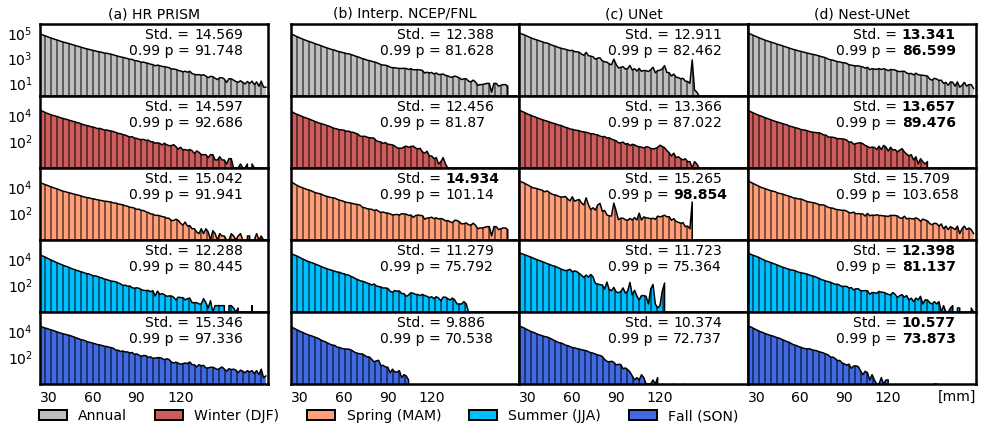

In [12]:
fig = plt.figure(figsize=(13, 5))
gs = gridspec.GridSpec(5, 5, width_ratios=[1, 0.1, 1, 1, 1])

AX1 = []; AX2 = []; AX3 = []; AX4 = []; AX5 = []
for i in [0, 2, 3, 4]:
    AX1.append(plt.subplot(gs[0, i]))
    AX2.append(plt.subplot(gs[1, i]))
    AX3.append(plt.subplot(gs[2, i]))
    AX4.append(plt.subplot(gs[3, i]))
    AX5.append(plt.subplot(gs[4, i]))
AX = [AX1, AX2, AX3, AX4, AX5]

plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0)

# ===== Macros ===== #
# keys & title settings
PCT_keys_plot = ['PRISM_PCT', 'PCT_REGRID', 'UNET_A', 'XNET_A']    
titles  = ['(a) HR PRISM', '(b) Interp. NCEP/FNL', '(c) UNet', '(d) Nest-UNet']
ylabels = ['Annual', 'Winter (DJF)', 'Spring (MAM)', 'Summer (JJA)', 'Fall (SON)']

# fonts
FW_std = [['normal', 'normal', 'normal', 'bold'], 
          ['normal', 'normal', 'normal', 'bold'], 
          ['normal', 'bold', 'normal', 'normal'], 
          ['normal', 'normal', 'normal', 'bold'], 
          ['normal', 'normal', 'normal', 'bold']]

FW_99p = [['normal', 'normal', 'normal', 'bold'], 
          ['normal', 'normal', 'normal', 'bold'], 
          ['normal', 'normal', 'bold', 'normal'], 
          ['normal', 'normal', 'normal', 'bold'], 
          ['normal', 'normal', 'normal', 'bold']]

# ===== Background features ===== #
YLIM = [5e5, 2.5e5, 2.5e5, 2.5e5, 2.5e5]
YTICKS = [[1e1, 1e3, 1e5], [1e2, 1e4], [1e2, 1e4], [1e2, 1e4], [1e2, 1e4]]

for i in range(5):
    for j in range(4):
        ax = AX[i][j]
        ax.set_yscale('log') # yaxis in log scale
        ax = gu.ax_decorate_box(ax)
        ax.set_xlim([pct_bins[0], pct_bins[-1]])
        ax.set_ylim([1, YLIM[i]])
    AX[i][0].tick_params(labelleft=True)
    AX[i][0].set_yticks(YTICKS[i])

for i in range(4):
    AX[-1][i].tick_params(labelbottom=True)
    AX[-1][i].set_xticks([30, 60, 90, 120])
    AX[0][i].set_title(titles[i], fontsize=14)
for i in range(5):
    AX[i][-1].yaxis.set_label_position("right")

AX[-1][-1].text(1, -0.225, '[mm]', fontsize=14, ha='right', transform=AX[-1][-1].transAxes)

# ===== Content ===== #

for i, sea in enumerate(['annual'] + seasons):
    for j, model in enumerate(PCT_keys_plot):
        AX[i][j].fill_between(pct_bins[:-1], np.zeros([99]), HIST['{}_{}'.format(model, sea)], 
                              facecolor=hist_colors[i], hatch='||') #
        AX[i][j].plot(pct_bins[:-1], HIST['{}_{}'.format(model, sea)], 'k-', lw=1.5)
        
        
        param = np.round(HIST['{}_{}_param'.format(model, sea)], 3)
        AX[i][j].text(0.675, 0.95, 'Std. = \n0.99 p = '.format(param[0]),
                     ha='right', va='top', fontsize=14, transform=AX[i][j].transAxes)
        
        AX[i][j].text(0.675, 0.95, '{}'.format(param[0]),
                     ha='left', va='top', fontsize=14, fontweight=FW_std[i][j], transform=AX[i][j].transAxes)
        AX[i][j].text(0.675, 0.725, '{}'.format(param[1]),
                     ha='left', va='top', fontsize=14, fontweight=FW_99p[i][j], transform=AX[i][j].transAxes)

# ===== Floating axis objects ===== #

legend_box = []
for i in range(5):
    legend_box.append(patches.Patch(facecolor=hist_colors[i], edgecolor='k', linewidth=2.0, label=ylabels[i]))

ax_lg = fig.add_axes([0.03, -0.085, 0.73, 0.05])
ax_lg.set_axis_off()
LG = ax_lg.legend(handles=legend_box, bbox_to_anchor=(1, 1), ncol=5, prop={'size':14});
LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(0)

# Save
fig.savefig(fig_dir+'PCT_FNL_distrib_verif.png', format='png', **fig_keys)